motive: We are attempting to use a constant-scaling method to perform endpoint estimations for beta and (possibly) gamma distributions. 
Basic steps are as follows:
1. Simulate a bunch of points and take some upper proportion p (upper thirds, upper quartile, etc.)
2. Calculate the standard deviation of the sample
3. Figure out what constant $c * \hat{\sigma}$ added to the sample maximum would get close to 1
4. Repeat 1-3 and obtain average of $c$ s.
5. Test on different Beta distributions (and maybe Gamma distributions). Is there a general rule?

In [17]:
#Import libraries here
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
import plotly.graph_objects as go 
seed = 2024
seeds = np.linspace(2020, 2120, 100).astype(int)

In [2]:
#Start with Beta(2,5) distribution
rng = np.random.default_rng(seed=seed)
sample = rng.beta(2,5,1000) #sample 1000 points from distribution
cutoff = np.percentile(sample, 66.7) #find cutoff for top third
test_sample = sample[sample > cutoff] #get top third
sd = np.std(test_sample) #get standard deviation
c = (1-np.max(test_sample)) / sd #get constant
print(c)

1.4094303685479377


In [15]:
#function for finding c:
def find_c(a, b, seeds):
    const_array = []
    for seed in seeds:
        rng = np.random.default_rng(seed=seed)
        sample = rng.beta(a,b,1000)
        cutoff = np.percentile(sample, 66.7)
        test_sample = sample[sample > cutoff]
        sd = np.std(test_sample)
        const_array.append((1-np.max(test_sample)) / sd)
    return const_array

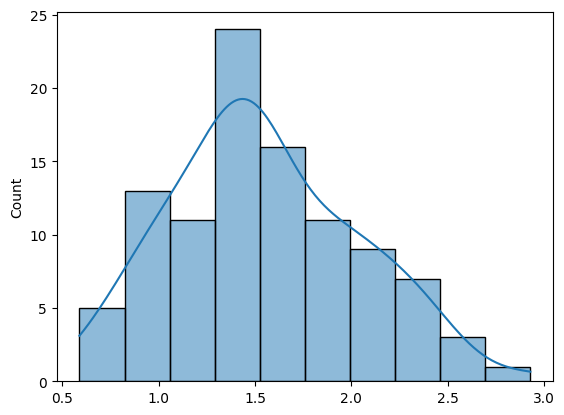

In [4]:
#repeat with different samples of Beta(2,5) distribution
c = find_c(2,5,seeds)

#plot distribution of constant cs
sns.histplot(x = c, kde = True, bins=10)
plt.show()

In [21]:
alphas = [0.5,1,2,3,4,5,6,7,8,9,10]
betas = [0.5,1,2,3,4,5,6,7,8,9,10]
xs = []
ys = []
cs = []
for a in alphas:
    for b in betas:
        for s in seeds:
            xs.append(a)
            ys.append(b)
        cs = cs + find_c(a,b,seeds)

In [23]:
fig = go.Figure(data=[go.Scatter3d(x=xs, y=ys, z=cs, mode='markers', marker=dict(size=6,color= cs, colorscale='Viridis'))])
fig.update_layout(scene = dict(
                    xaxis_title='alpha',
                    yaxis_title='beta',
                    zaxis_title='scaling constant'),
                    margin=dict(r=20, b=10, l=10, t=10))
fig.show()

In [24]:
fig2 = go.Figure(data=[go.Mesh3d(x=xs, y=ys, z=cs, color='rgba(244,22,100,0.6)')])
fig2.update_layout(scene = dict(
                    xaxis_title='alpha',
                    yaxis_title='beta',
                    zaxis_title='scaling constant'),
                    margin=dict(r=20, b=10, l=10, t=10))
fig2.show()

c seems to increase as beta increases and decreases as alpha increases, which we don't want. (We want c to be constant). The first idea is to adjust cutoff point to change the number of points sampled based on skewness. 

In [10]:
#c exhibits linear trend (which we don't want), try using skew of the distribution to correct c?
alphas = [0.5,1,2,3,4,5,6,7,8,9,10]
betas = [0.5,1,2,3,4,5,6,7,8,9,10]
xs = []
ys = []
skew = []
for a in alphas:
    for b in betas:
        for s in seeds:
            rng = np.random.default_rng(seed=s)
            sample = rng.beta(a,b,1000)
            xs.append(a)
            ys.append(b)
            skew.append(sc.skew(sample))

NameError: name 'fig' is not defined

In [13]:
fig3 = go.Figure(data=[go.Scatter3d(x=xs, y=ys, z=skew, mode='markers', marker=dict(size=6,color= skew, colorscale='Viridis'))])
fig3.update_layout(scene = dict(
                    xaxis_title='alpha',
                    yaxis_title='beta',
                    zaxis_title='skewness'),
                    margin=dict(r=20, b=10, l=10, t=10))
fig3.show()

Hypothesis 1: lower cutoff (increase proportion of points sampled) for negatively skewed distributions and higher cutoff (decrease proportion of points sampled) for positively skewed distributions.

In [46]:
def find_c2(a, b, seeds):
    const_array = []
    for seed in seeds:
        rng = np.random.default_rng(seed=seed)
        sample = rng.beta(a,b,1000)
        cutoff = np.percentile(sample, 66.7+sc.skew(sample)*1.5)
        test_sample = sample[sample > cutoff]
        sd = np.std(test_sample)
        const_array.append((1-np.max(test_sample)) / sd)
    return const_array

In [49]:
def graph_cs(findc):
    alphas = [0.5,1,2,3,4,5,6,7,8,9,10]
    betas = [0.5,1,2,3,4,5,6,7,8,9,10]
    xs = []
    ys = []
    cs = []
    for a in alphas:
        for b in betas:
            for _ in seeds:
                xs.append(a)
                ys.append(b)
            cs = cs + findc
    fig = go.Figure(data=[go.Scatter3d(x=xs, y=ys, z=cs, mode='markers', marker=dict(size=6,color= cs, colorscale='Viridis'))])
    fig.update_layout(scene = dict(
                        xaxis_title='alpha',
                        yaxis_title='beta',
                        zaxis_title='scaling constant'),
                        margin=dict(r=20, b=10, l=10, t=10))
    fig.show()
    
    fig2 = go.Figure(data=[go.Mesh3d(x=xs, y=ys, z=cs, color='rgba(244,22,100,0.6)')])
    fig2.update_layout(scene = dict(
                        xaxis_title='alpha',
                        yaxis_title='beta',
                        zaxis_title='scaling constant'),
                        margin=dict(r=20, b=10, l=10, t=10))
    fig2.show()
    

In [50]:
graph_cs(find_c2(a,b,seeds=seeds))

In [ ]:
graph_cs(find_c2(a,b,seeds=2024))